# NLP 4: Sentiment Analysis

Practice classifying tweets to tell if they are positive or negative. It could be a very useful tool to optimize the work of a community manager.

## Task 1

* Import [this dataset](https://github.com/murpi/wilddata/raw/master/quests/tweets.zip) of tweets into a DataFrame.

In [171]:
# Necessary modules
import re
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# spaCy section
import spacy
from spacy.tokens import Doc

# Import of English rules
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Setting this to display entire tweet length in dataframe printout
pd.set_option('max_colwidth', 400)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pivanov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Read the dataset using the zip compression
df = pd.read_csv("https://github.com/murpi/wilddata/raw/master/quests/tweets.zip",compression='zip')
 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


## Task 2

* Keep only positive and negative tweets (so you exclude `neutrals`). What is the percentage of positive/negative tweets?

positive    52.45
negative    47.55
Name: sentiment, dtype: float64


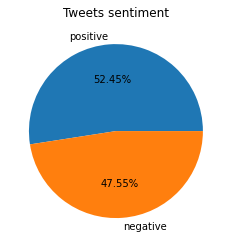

In [52]:
# Removing "neutral" tweets
df = df[~(df["sentiment"]=="neutral")]

# Extracting counts for positive and negative
data = df["sentiment"].value_counts() 

# Computing the percentages
print (f"{round(data * 100 / data.sum(), 2)}")

# Plot! Why not.
fig, ax = plt.subplots()
plt.pie(x=data, labels=data.index.values, autopct='%.2f%%')
fig.set_facecolor('white')
ax.set_title("Tweets sentiment")
plt.show()

## Task 3

* Retrieve the list of English stopwords from NLTK, and copy it into a `stopwordsenglish` list.

In [55]:
stopwordsenglish = set(stopwords.words('english'))

## Task 4

* Create a `lemma` function that takes a text (`str`) as a parameter and returns a text (`str`) of tokens after applying a stemmer or a lemmatizer, separated by spaces.

In [122]:
# This will lemmatize and lowercase text and remove punctuation at one go
def lemma_punct(text):
    l = WordNetLemmatizer()

    # Initializing output
    output = ""

    # This could be done in very very long list comprehension line,
    # but I like readability better
    for word in text.split():

        # Removing punctuation 1
        if not(re.match("^\W+$", word)):
            
            # Removing punctuation 2
            word = re.sub("\W$", "", word)

            # Lowercase
            word = word.lower()

            # Lemmatize
            word = l.lemmatize(word)

        output = (output + " " + word).strip()
    
    return output

# Super-simple-stupid lemma (because the matrix shape below didn't match the expected count)
# and it really doesn't do much
def lemma_stupid(text):

    l = WordNetLemmatizer()
  
    return " ".join([l.lemmatize(word) for word in text.split()])


# spaCy lemma - the good one
def lemma(text):
    
    # Tokenizin'
    doc = nlp(text)

    # Lemmatizin'
    return " ".join([token.lemma_.lower() for token in doc])


# A test:    
lemma("Retrieved the list of English vaccines and copied them.")

'retrieve the list of english vaccine and copy they .'

## Task 5

* Apply this function `lemma` to the `text` column of your DataFrame. Store the result in a new `lemma` column of the DataFrame. (The processing can take 2 or 3 minutes).

In [123]:
df["lemma"] = df["text"].apply(lemma)

df.sample(30)

,textID,text,selected_text,sentiment,lemma
2918,852cd2b9c1,"Pics? Ah, I`ll probably see you at work at so...",Hopefully,positive,"pic ? ah , i`ll probably see you at work at ..."
7305,4492448111,yeah I didn`t realize how bad it all was till...,e how bad it all was,negative,yeah i didn`t realize how bad it all be till...
13734,a946e76161,**** **** and blast! I`m at LMHR tomorrow an...,blast!,positive,* * * * * * * * and blast ! i`m at lmhr to...
20207,e6d92f0556,Gone r the days wen we used to sit 4 exams.. n...,no more fun..,negative,go r the day wen we use to sit 4 exam .. no mo...
24178,c0c213673f,Today is just not my day. I can`t seem to feel...,Today is just not my day.,negative,today be just not my day . i can`t seem to fee...
22768,b31a0ce70d,"--sorry for running over uncle Terry, but he ...",-sorry,negative,"--sorry for run over uncle terry , but he ju..."
15036,a8c7169a40,Im so down! The AC in my house just broke,Im so down!,negative,i m so down ! the ac in my house just break
14307,1ca884fc2c,C-News wasn`t as bad as I expected... could ha...,better..,positive,c - news wasn`t as bad as i expect ... could h...
7410,3463ecdfd6,Im.in.the.room Im.watching.the.HANNAHmovie.wit...,great.,positive,im.in.the.room im.watching.the.hannahmovie.wit...
9345,1d8f09c16c,I still haven`t figured out what to do with t...,sadly,negative,i still haven`t figure out what to do with t...


## Task 6

* Copy the `lemma` column into a __Series__ `X`, and the `sentiment` column into a __Series__ `y`. Apply a train test split with the `random_state = 32`.

In [124]:
# Copyjob
x = df["lemma"].copy()
y = df["sentiment"].copy()

# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=32)

x_train.shape, x_test.shape

((12272,), (4091,))

## Task 7

* Create a `vectorizer` model with scikit-learn using the `Countvectorizer` method. Train your model on `X_train`, then create a matrix of _features_ `X_train_CV`. Create the `X_test_CV` matrix without re-training the model. The format of the `X_test_CV` matrix should be `4091x13838` with `44274 stored elements`.

In [125]:
# Fittin'
vectorizer = CountVectorizer().fit(x_train)

# Vectorizin'
x_train_cv = vectorizer.transform(x_train)
x_test_cv = vectorizer.transform(x_test)

x_test_cv

<4091x13790 sparse matrix of type '<class 'numpy.int64'>'
	with 44306 stored elements in Compressed Sparse Row format>

## Task 8

* Using `X_train_CV` and `y_train`, please run a logistic regression to classify tweets. You should get a score of `0.87` on the `X_test_CV` test set.

In [128]:
# Regressin'
LR_model = LogisticRegression().fit(x_train_cv, y_train)

# Testin'
LR_model.score(x_test_cv, y_test)

C:\Users\pivanov\Apps\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8772916157418724

## Task 9

* Repeat steps 7 and 8, adding the `stop_words` parameter to the CountVectorizer, using your `stopwordsenglish` list from step 3. Is the score very different? Is the number of elements stored in the sparse matrix very different?

In [129]:
# Fittin'
vectorizer = CountVectorizer(stop_words=stopwordsenglish).fit(x_train)

# Vectorizin'
x_train_cv = vectorizer.transform(x_train)
x_test_cv = vectorizer.transform(x_test)

x_test_cv

<4091x13657 sparse matrix of type '<class 'numpy.int64'>'
	with 26433 stored elements in Compressed Sparse Row format>

__Answer__:  
The amount of stored elements dropped down to ~60%.

In [130]:
# Regressin'
LR_model = LogisticRegression().fit(x_train_cv, y_train)

# Testin'
LR_model.score(x_test_cv, y_test)

0.8645807870936202

__Answer__:  
Score is not very different, accuracy went actually down a bit.

## Task 10

 * Test the model using `TfidfVectorizer` instead of `Countvectorizer`, and repeat steps 7 and 8. Which preprocessing method gives you the best results on the test set? Are the scores very different on this dataset?

In [133]:
# Tfidfvectorizin'
vectorizer = TfidfVectorizer().fit(x_train)

# Vectorizin'
x_train_cv = vectorizer.transform(x_train)
x_test_cv = vectorizer.transform(x_test)

# Regressin'
LR_model = LogisticRegression().fit(x_train_cv, y_train)

# Testin'
LR_model.score(x_test_cv, y_test)

0.8799804448790027

__Answer__:  
Best preprocessing method was _TfidfVectorizer WITHOUT stopwords removal_. Accuracy score was _0.88_ on this test set.  
The scores actually didn't significantly change. All have been in range $<0.86, 0.88>$.

## Task 11

* Bonus step: try to display 10 tweets that were badly predicted (false positive or false negative). Would you have done better than the algorithm?

In [164]:
# Creating a function which makes a prediction using:
#   - given text
#   - already fitted vectorizer
#   - already fitted model
def LR_model_predict(string, vectorizer, model):
    # Here the string must be a single element of a list
    # otherwise vectorizer won't work (expects iterable).
    # `string_vector` is sparse matrix which LR_model understands and can predict on.
    string_vector = vectorizer.transform([string])
    
    # Return prediction
    return LR_model.predict(string_vector)[0]

# Test
print(f"{LR_model_predict('rain make for a good study day almost do ! !', vectorizer, LR_model)}")


positive


In [166]:
# Now I will just fill the dataframe with model predictions :)
df["prediction"] = df["lemma"].apply(LR_model_predict, args=(vectorizer, LR_model))

,textID,text,selected_text,sentiment,lemma,prediction
17,919fa93391,i`ve been sick for the past few days and thus...,sick,negative,"i`ve be sick for the past few day and thus ,...",positive
28,6ce4a4954b,juss came backk from Berkeleyy ; omg its madd ...,fun,positive,juss come backk from berkeleyy ; omg its madd ...,negative
32,1c31703aef,If it is any consolation I got my BMI tested ...,well so much for being unhappy for about 10 mi...,negative,if it be any consolation i get my bmi test h...,positive
48,3d9d4b0b55,"i donbt like to peel prawns, i also dont like ...",dont like go,negative,"i donbt like to peel prawn , i also do nt like...",positive
76,35f393a245,"WOW, i AM REALLY MiSSiN THE FAM(iLY) TODAY. BA...",BADDD.,negative,"wow , i be really missin the fam(ily ) today ....",positive
...,...,...,...,...,...,...
27371,e07daddcc5,i have a crush on someone!,i have a crush on someone!,positive,i have a crush on someone !,negative
27420,24fa941c24,I would but you`re too far away,too far away,negative,i would but you`re too far away,positive
27428,e02ea8a95c,i hate my presentation hahah whatever im glad...,im glad,positive,i hate my presentation hahah whatever i m gl...,negative
27440,7fd422900b,I GET IT. YOU ESPLAINED IT TO ME AWHILE AGO.,I GET IT.,negative,i get it . you esplained it to me awhile a...,positive


In [172]:
# Let's get 10 which were not well predicted
df.loc[df["sentiment"]!=df["prediction"],["text", "sentiment", "prediction"]].sample(10)

,text,sentiment,prediction
12744,i wishhh!,positive,negative
21870,looking at this website!! should be working!!,positive,negative
8522,hahaha is SUCH nonsense,negative,positive
25456,"Oh, my God..... The end of the first course))) don`t believe in it) but, yeh, so many exams La-la-la// everything is wonderful!!!!!!!!!!",positive,negative
21100,i know but it will make us all watch the awards on sunday! lol..i want to shower and there is no water!,negative,positive
8593,FOOOOOD yummy so. whose washing the dishes now ? NOT ME ! not i .. rofl,positive,negative
3839,shopping is therapuetic and i`m all about bettering myself... i need financing for my therapy however,positive,negative
20460,"KERI HILSON- SLOW DANCE ROCKIN` THE **** OUT OF MY PLAYLIST RIGHT NOW! GET UP ON THIS SONG, PURE **** DROPPER",positive,negative
19952,"If you think Florida`s heat will be too much, I will reluctantly take your place",negative,positive
17882,"Bed!!!!!... its time,..... hope i go to school tomorrow, all though i don`t feel very well right now",negative,positive


__Answer__:  
I did better than the model, but I didn't get 100% accuracy on the sample either.
